## MRCONSO Data Exploration and Preprocessing

This notebook does some basic data exploration of the MRCONSO.RRF file downloaded from the NIH UMLS site.

We then sample 5000 CUIs with multiple synonyms (>5) from MRCONSO, normalize the synonyms to remove punctuation and lowercase, then sample positive pairs (anchor, positive) for these CUIs, between 3 and 5 positive pairs for each CUI in the sampled set.

### Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import polars as pl
import re

%matplotlib inline

### Read Data

In [3]:
DATA_DIR = "../data"
INPUT_FILE = os.path.join(DATA_DIR, 'MRCONSO.RRF')
OUTPUT_FILE = os.path.join(DATA_DIR, "positive_pairs.tsv")

In [4]:
mrconso_columns = ["CUI", "LAT", "TS", "LUI", "STT", "SUI", "ISPREF",
           "AUI", "SAUI", "SCUI", "SDUI", "SAB", "TTY", "CODE",
           "STR", "SRL", "SUPPRESS", "CVF", "METAUI"]
mrconso_df = pl.read_csv(INPUT_FILE,
                         separator='|',
                         quote_char=None,
                         has_header=False,
                         new_columns=mrconso_columns,
                         encoding='utf8-lossy')
mrconso_df.head()

CUI,LAT,TS,LUI,STT,SUI,ISPREF,AUI,SAUI,SCUI,SDUI,SAB,TTY,CODE,STR,SRL,SUPPRESS,CVF,METAUI
str,str,str,str,str,str,str,str,i64,str,str,str,str,str,str,i64,str,i64,str
"""C0000005""","""ENG""","""P""","""L0000005""","""PF""","""S0007492""","""Y""","""A26634265""",null,"""M0019694""","""D012711""","""MSH""","""PEP""","""D012711""","""(131)I-Macroag…",0,"""N""",256,null
"""C0000005""","""ENG""","""S""","""L0270109""","""PF""","""S0007491""","""Y""","""A26634266""",null,"""M0019694""","""D012711""","""MSH""","""ET""","""D012711""","""(131)I-MAA""",0,"""N""",256,null
"""C0000005""","""FRE""","""P""","""L6220710""","""PF""","""S7133957""","""Y""","""A13433185""",null,"""M0019694""","""D012711""","""MSHFRE""","""PEP""","""D012711""","""Macroagrégats …",3,"""N""",null,null
"""C0000005""","""FRE""","""S""","""L6215648""","""PF""","""S7133916""","""Y""","""A27488794""",null,"""M0019694""","""D012711""","""MSHFRE""","""ET""","""D012711""","""MAA-I 131""",3,"""N""",null,null
"""C0000005""","""FRE""","""S""","""L6215656""","""PF""","""S7133956""","""Y""","""A27614225""",null,"""M0019694""","""D012711""","""MSHFRE""","""ET""","""D012711""","""Macroagrégats …",3,"""N""",null,null


In [5]:
len(mrconso_df)

13609918

### Consider English synonyms for non-suppressed entities only

In [6]:
cuisyn_df = (mrconso_df
             .filter((mrconso_df["LAT"] == "ENG") & 
                     (mrconso_df["SUPPRESS"] == "N"))
             .select(["CUI", "STR"]))
cuisyn_df.head()

CUI,STR
str,str
"""C0000005""","""(131)I-Macroag…"
"""C0000005""","""(131)I-MAA"""
"""C0000039""","""1,2-dipalmitoy…"
"""C0000039""","""1,2-dipalmitoy…"
"""C0000039""","""1,2-Dipalmitoy…"


In [7]:
len(cuisyn_df)

8603906

### How many unique CUIs?

In [8]:
unique_cuis = cuisyn_df.select(["CUI"]).unique()
len(unique_cuis)

3185657

### Synonym Normalization and Cleanup

In [9]:
def lowercase(syn):
    syn = syn.lower()
    syn = re.sub(r'[^\w\s]', ' ', syn)
    syn = re.sub(r'\s+', ' ', syn)
    return syn


cuisyn_lc_df = (cuisyn_df
                .with_columns(pl.col("STR").map_elements(lowercase))
                .unique(subset=["STR"]))
cuisyn_lc_df.head()

CUI,STR
str,str
"""C1572367""","""mycophenolate …"
"""C0070331""","""pepstatyl gly …"
"""C1525260""","""xr tib fib vie…"
"""C2042286""","""magnetic reson…"
"""C2027346""","""mri cervical o…"


### Distribution of number of synonyms per CUI

In [10]:
syns_by_cui_df = (cuisyn_lc_df
                  .group_by("CUI")
                  .agg(pl.count("STR").alias("num_syns"))
                  .sort("num_syns", descending=True)
                  )
syns_by_cui_df.head()

CUI,num_syns
str,u32
"""C1612374""",671
"""C1613478""",473
"""C0973749""",305
"""C1815705""",291
"""C2945898""",286


In [11]:
pl.Config.set_fmt_str_lengths(120)
cuisyn_lc_df.filter(cuisyn_lc_df["CUI"] == "C1612374").head()

CUI,STR
str,str
"""C1612374""","""alcohol 0 7 ml in 1 ml topical gel basic care """
"""C1612374""","""alcohol 41 40297 ml in 59 15 ml cutaneous gel prima fleur hand sanitizer """
"""C1612374""","""alcohol 0 7 g in 1 ml topical gel antimicrobial hand sanitizer """
"""C1612374""","""alcohol 0 7 ml in 1 ml topical gel margaritaville apple """
"""C1612374""","""alcohol 0 7 l in 1 l topical gel sanit hand sanitizer """


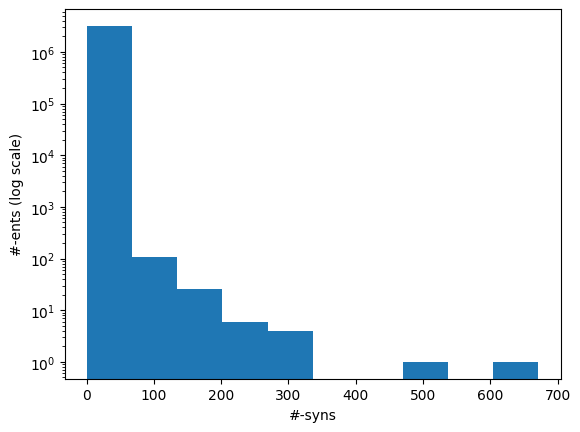

In [12]:
num_syns = syns_by_cui_df["num_syns"].to_list()
plt.yscale("log")
plt.ylabel("#-ents (log scale)")
plt.xlabel("#-syns")
_ = plt.hist(num_syns)

### Random Sampling

For Hard Negative Mining, we will need to vectorize the synonyms. Since vectorization is expensive and we don't need all 8M syns vectorized, we will sample pairs from non-rare entities.

In [13]:
cui_sample_df = (syns_by_cui_df
                 .filter(syns_by_cui_df["num_syns"] > 5)
                 .select(["CUI"])
                 .sample(n=5000, 
                         with_replacement=False,
                         seed=42))
cui_sample_df.head()

CUI
str
"""C0691017"""
"""C4048541"""
"""C0232950"""
"""C2179347"""
"""C4301888"""


In [14]:
len(cui_sample_df)

5000

In [15]:
len(cui_sample_df.unique())

5000

### Join with normalized syns dataframe

This creates a reduced dataframe with only STR from our sampled CUIs.

In [16]:
cui_syn_sample_df = cuisyn_lc_df.join(cui_sample_df, on="CUI")
len(cui_syn_sample_df)

46656

### Self-join on CUI to find positive (Anchor-Positive) pairs

In [18]:
cui_syn_pairs_df = (cui_syn_sample_df
                    .join(cui_syn_sample_df, on="CUI")
                    .rename({"STR": "STR_A", "STR_right": "STR_P"})
                    )
cui_syn_pairs_df = cui_syn_pairs_df.filter(
    cui_syn_pairs_df["STR_A"] != cui_syn_pairs_df["STR_P"])

cui_syn_pairs_df.head()

CUI,STR_A,STR_P
str,str,str
"""C0041218""","""trypanosoma trypanozoon brucei gambiense""","""gambienses trypanosoma"""
"""C0041218""","""trypanosoma gambiense""","""gambienses trypanosoma"""
"""C0041218""","""trypanosoma brucei gambienses""","""gambienses trypanosoma"""
"""C0041218""","""trypanosoma hominis""","""gambienses trypanosoma"""
"""C0041218""","""trypanosoma ugandense""","""gambienses trypanosoma"""


In [19]:
len(cui_syn_pairs_df)

628838

### Randomly sample 3-5 pairs for each CUI

In [20]:
final_pairs_df = pl.DataFrame({}, schema=cui_syn_pairs_df.schema)
for row in cui_sample_df.iter_rows():
    cui = row[0]
    num_to_sample = np.random.randint(3, 6)
    sample_df = (cui_syn_pairs_df
                 .filter(cui_syn_pairs_df["CUI"] == cui)
                 .sample(n=num_to_sample,
                         with_replacement=False,
                         seed=42)
                )
    final_pairs_df.extend(sample_df)

final_pairs_df.head()

CUI,STR_A,STR_P
str,str,str
"""C0691017""","""lidocaine hcl 4mg ml dextrose 5 inj""","""lidocaine hydrochloride injectable 5 0 4 injectable solution"""
"""C0691017""","""lignocaine hydrochloride glucose 0 4 5 polyfusor""","""lignocaine hydrochloride glucose 0 4 5 infusion"""
"""C0691017""","""lidocaine hydrochloride 4 mg ml injection""","""lidocaine hcl 4mg ml dextrose 5 inj"""
"""C4048541""","""remifentanil hydrochloride 1 mg in 1 ml intravenous injection powder lyophilized for solution ultiva _ 1""","""ultiva 1mg powder for injection"""
"""C4048541""","""ultiva 1mg powder for injection""","""remifentanil hydrochloride 1 mg intravenous powder for solution ultiva novaplus """


In [21]:
len(final_pairs_df)

19952

In [22]:
len(final_pairs_df.select(["CUI"]).unique())

5000

### Write out to a TSV file

In [23]:
final_pairs_df.write_csv(OUTPUT_FILE, separator='\t')